In [83]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [84]:
# Specify Model
reduced = False
model_type = 'keras' # keras or h5 or onnx
factor_index = 0

# Load Model    

In [85]:
# Load the model
model_url = '../models/fitmotion_model'
if reduced:
    model_url += '_reduced'

if model_type == 'keras':
    model = keras.models.load_model(model_url + '.keras')
elif model_type == 'h5':
    model = tf.keras.models.load_model(model_url + '.h5')
elif model_type == 'onnx':
    import onnx
    import onnxruntime as ort
    sess = ort.InferenceSession(model_url + '.onnx')


labels = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

/home/rayhannarindran/programming/python/miniconda3/envs/tf-testing/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Loading The Data

### Native Android Data

In [86]:
# Load Android Data
data_source = 'android_data_latest'
if reduced:
    data_source += '_reduced'
data_type = 'wlk'
data_num = '5'
data_url = '../data/' + data_source + '/' + data_type + '/' + data_type + data_num + '-SensorData.csv'

df = pd.read_csv(data_url, sep=',')
    
df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
df = df.drop(['id'], axis=1) if 'id' in df.columns else df
df

,Attitude Roll,Attitude Pitch,Attitude Azimuth,Gravity X,Gravity Y,Gravity Z,Rotation Rate X,Rotation Rate Y,Rotation Rate Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,0.646824,2.541451,-2.886259,2.747842,-9.411865,-0.191146,0.000432,0.003521,0.003685,0.004314,0.026667,-0.313147
1,0.646824,2.541451,-2.886259,2.747842,-9.411865,-0.191146,0.000432,0.003521,0.003685,0.004314,0.026667,-0.313147
2,0.646824,2.541451,-2.886259,2.747842,-9.411865,-0.191146,0.000432,0.003521,0.003685,0.004314,0.026667,-0.313147
3,0.667742,2.499000,-2.874172,2.802586,-9.396373,-0.155226,-0.002059,0.001346,0.003886,-0.053072,-0.148451,-0.302652
4,0.667742,2.499000,-2.874172,2.802586,-9.396373,-0.155226,-0.002059,0.001346,0.003886,-0.053072,-0.148451,-0.302652
...,...,...,...,...,...,...,...,...,...,...,...,...
1798,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049
1799,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049
1800,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049
1801,0.729146,2.372624,-2.879067,3.218944,-9.248426,-0.524771,-0.001387,0.001796,-0.001230,-0.043334,0.032101,0.014049


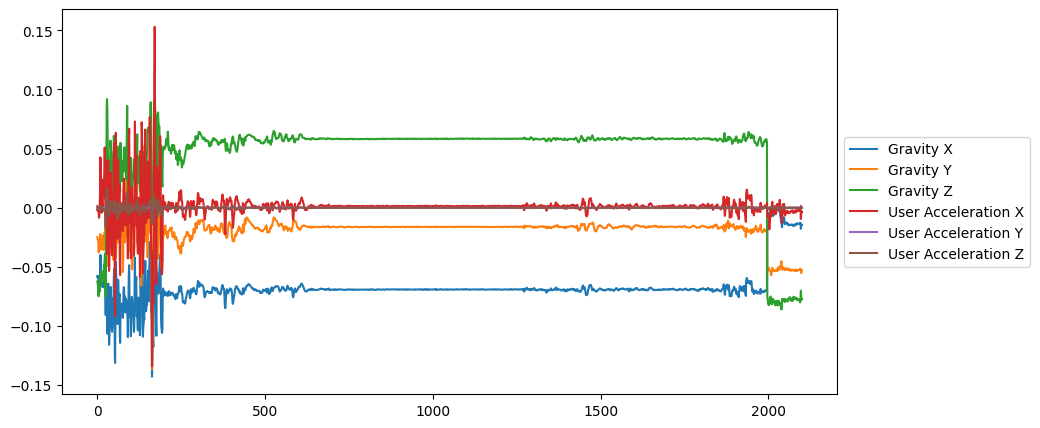

In [47]:
# Check Data by Plotting
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [48]:
# Remove Noise Data
df = df.iloc[200:1600]

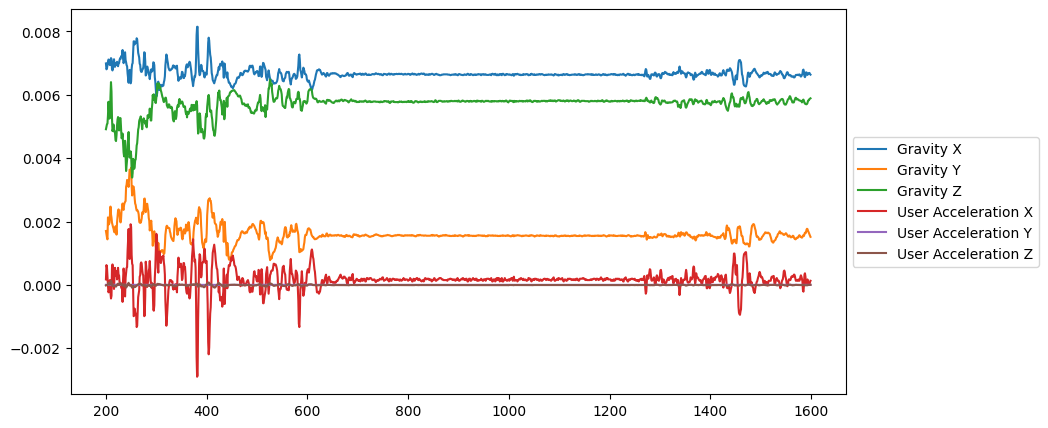

In [53]:
# Check Data by Plotting
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Original Data

In [88]:
# Load Orignal Data (for comparison)
data_source_o = 'dataset'
if reduced:
    data_source_o += '_reduced'
data_type_o = 'wlk_7'
data_num_o = '4'
data_url_o = '../data/' + data_source_o + '/' + data_type_o + '/' + 'sub_' + data_num_o + '.csv'

df_o = pd.read_csv(data_url_o)
df_o = df_o.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df_o.columns else df_o
df_o

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.569732,-1.344266,-1.316934,-0.121138,0.974452,-0.189103,-1.811013,0.851841,-1.083774,-0.779741,0.495672,0.594301
1,-0.721397,-1.359857,-1.513063,-0.138265,0.977835,-0.157201,-1.819990,2.591707,-1.137348,-0.416377,0.541651,0.354757
2,-0.783814,-1.362296,-1.637286,-0.146117,0.978342,-0.146581,-0.312856,2.677489,-0.719938,-0.162065,0.567739,-0.526576
3,-0.843923,-1.361021,-1.717798,-0.155590,0.978078,-0.138367,-1.028269,0.311309,-0.581966,-0.059711,-0.361272,0.916244
4,-0.963102,-1.372325,-1.850983,-0.161848,0.980369,-0.112564,-1.584632,1.038291,-0.216111,0.075652,-0.448585,0.873779
...,...,...,...,...,...,...,...,...,...,...,...,...
6466,2.777965,-1.396517,2.101557,0.061636,0.984852,0.161966,-0.752626,-0.267981,-0.164063,0.076166,-0.070347,0.081533
6467,2.824490,-1.381503,2.147944,0.058643,0.982137,0.178694,-0.888023,0.235275,-0.158176,0.105572,-0.046499,0.047472
6468,2.882559,-1.366061,2.201221,0.052053,0.979115,0.196437,-0.881749,0.229726,-0.373906,0.133692,0.118724,-0.085262
6469,2.944159,-1.349287,2.266074,0.043079,0.975567,0.215352,-1.083126,-0.314477,-0.503870,0.171902,0.122944,-0.341450


# Data Cleaning

In [72]:
# Removing Outliers from Data
def remove_outliers(df):
    result = df.copy()
    for feature in df.columns:
        if pd.api.types.is_numeric_dtype(df[feature]):
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            result = result[(result[feature] >= lower_bound) & (result[feature] <= upper_bound)]
    return result

df = remove_outliers(df)

In [89]:
# opening scaling factor file to read the dictionary
constants_url = '../constants_reduced.txt' if reduced else '../constants.txt'

factors = []
with open(constants_url, 'r') as f:
    lines = f.readlines()
    for line in lines:
        factors.append(eval(line))
factors

[{'Attitude Roll': 0.10221185575559373,
  'Attitude Pitch': -0.579862596228045,
  'Attitude Azimuth': 0.149674824612691,
  'Gravity X': -0.03662049398772467,
  'Gravity Y': -0.10313028288385923,
  'Gravity Z': 0.013434455373251402,
  'Rotation Rate X': -0.9411218581638958,
  'Rotation Rate Y': -0.04620051888800989,
  'Rotation Rate Z': -0.0361597418352225,
  'User Acceleration X': -0.02147556597863703,
  'User Acceleration Y': 0.1246765894102864,
  'User Acceleration Z': 0.0985925988387502}]

In [90]:
# Multiply data with constants
for i in range(len(df.columns)):
    df.iloc[:, i] = df.iloc[:, i] * factors[factor_index][df.columns[i]]

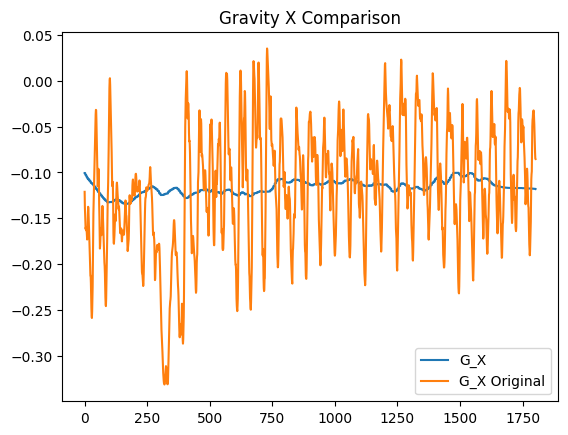

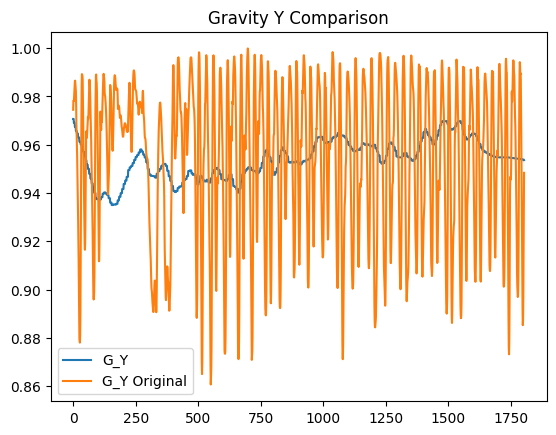

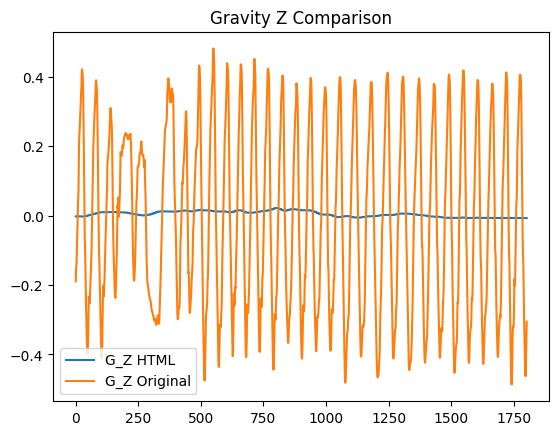

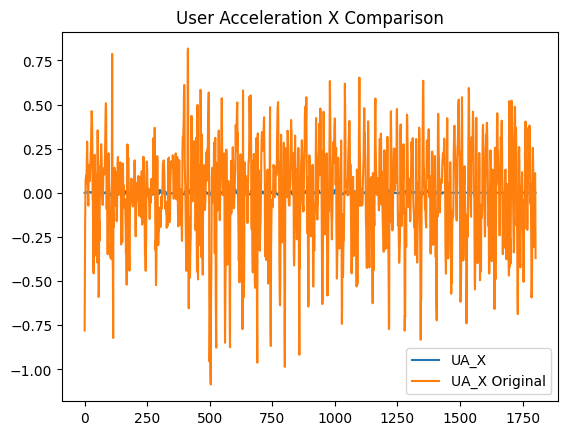

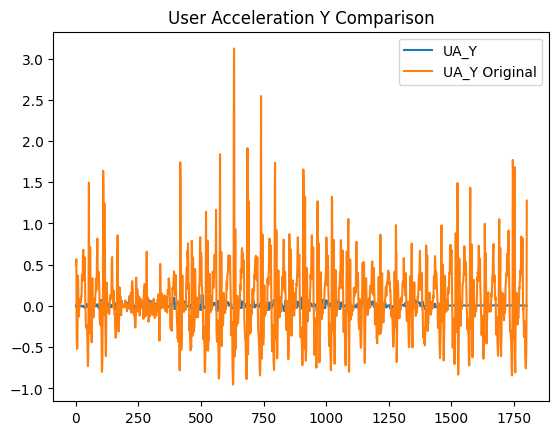

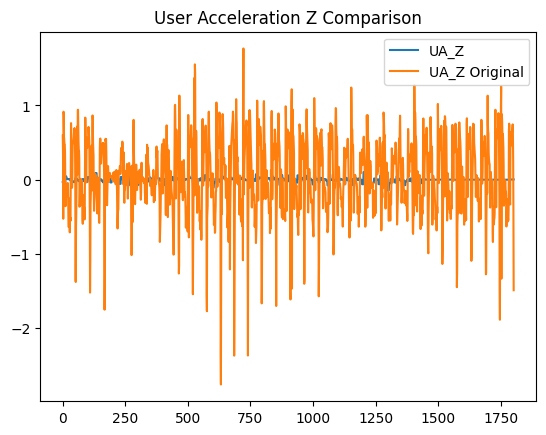

In [91]:
# Check Data Similiraties
plt.title('Gravity X Comparison')
plt.plot(df['Gravity X'], label='G_X')
plt.plot(df_o['gravity.x'].iloc[0:len(df)], label='G_X Original')
plt.legend()
plt.show()

plt.title('Gravity Y Comparison')
plt.plot(df['Gravity Y'], label='G_Y')
plt.plot(df_o['gravity.y'].iloc[0:len(df)], label='G_Y Original')
plt.legend()
plt.show()

plt.title('Gravity Z Comparison')
plt.plot(df['Gravity Z'], label='G_Z HTML')
plt.plot(df_o['gravity.z'].iloc[0:len(df)], label='G_Z Original')
plt.legend()
plt.show()

plt.title('User Acceleration X Comparison')
plt.plot(df['User Acceleration X'], label='UA_X')
plt.plot(df_o['userAcceleration.x'].iloc[0:len(df)], label='UA_X Original')
plt.legend()
plt.show()

plt.title('User Acceleration Y Comparison')
plt.plot(df['User Acceleration Y'], label='UA_Y')
plt.plot(df_o['userAcceleration.y'].iloc[0:len(df)], label='UA_Y Original')
plt.legend()
plt.show()

plt.title('User Acceleration Z Comparison')
plt.plot(df['User Acceleration Z'], label='UA_Z')
plt.plot(df_o['userAcceleration.z'].iloc[0:len(df)], label='UA_Z Original')
plt.legend()
plt.show()

# Preprocessing Data

In [92]:
# Prepare the data
WINDOW_LENGTH = 150
STRIDE_LENGTH = 10
NUM_CLASSES = 6 if reduced else 12
NUM_FEATURES = 12
BATCH_SIZE = 100
EPOCHS_SIZE = 10

In [93]:
from scipy.stats import mode

def sequence_generator(x, length, stride):
    seq_x = []
    data_length = len(x)

    for i in range(0, data_length - length + 1, stride):
        input_sequence = x.iloc[i : i + length]
        seq_x.append(input_sequence)
    return np.array(seq_x)

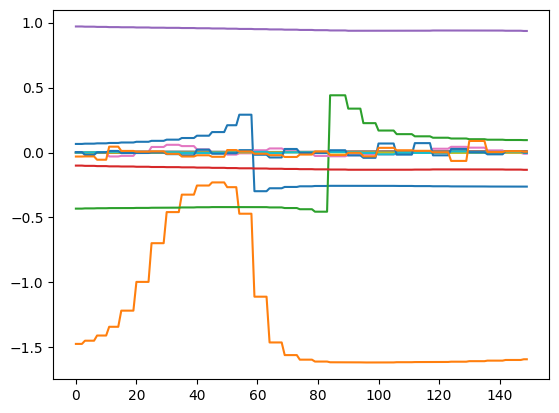

In [94]:
# Checking data
import matplotlib.pyplot as plt

tx = sequence_generator(df, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(tx[0])
plt.show()

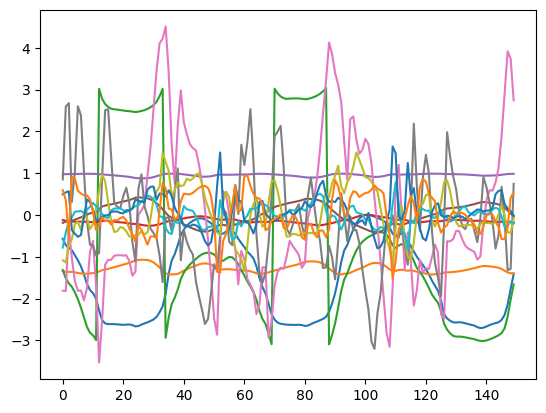

In [95]:
txc = sequence_generator(df_o, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(txc[0])
plt.show()

# Prediction

In [96]:
if model_type == 'onnx':
    # Predict with ONNX
    tx = tx.astype(np.float32)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    y_pred = sess.run([output_name], {input_name: tx})[0]
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]
else: 
    # Predict the data
    y_pred = model.predict(tx)

    # Get the most frequent label
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]

print(labels[y_pred])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
std
